In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
from Backtesting import *

In [3]:
directory = "O:/AARM/Direct/Top Holdings/Research/Biotech/NW/"

bt_data = BacktesterData(
    holdings_path=directory + 'Output/holdings.csv',
    sec_master_path=directory + 'Output/security_master.csv',
    sec_mapping_path=directory + 'Output/security_mapping.csv',
    sec_out_path=directory + 'Output/security_out.csv',
    managers_path=directory + 'Input/managers.xlsx'
)

In [4]:
bt = FilingBacktester(bt_data)
pd.set_option('future.no_silent_downcasting', False)

In [5]:
mkt_cap = bt.sec_mkt_cap_df
eligible = bt.eligible_securities_df
rets = bt.sec_rets_df
valid_rets = (rets == 0).sum(axis=1) < 0.9*len(rets.columns)
mkt_cap = mkt_cap.multiply(eligible)
mkt_cap = mkt_cap.replace(0, np.nan)
mkt_cap = mkt_cap.loc[valid_rets]
rets = rets.loc[valid_rets]

# Size
size_score = np.log(mkt_cap)
size_score = bt.standardize_factor_scores(size_score).shift(1)

# Separate Reversal (short-term) and Momentum (long-term) factors
MOMENTUM_LONG_PERIOD = 252 #~1 year
REVERSAL_PERIOD = 21 #~1 month

# Long-term momentum component
# Calculate returns excluding the most recent REVERSAL_PERIOD (21 days)
# and including only the period from t-MOMENTUM_LONG_PERIOD to t-REVERSAL_PERIOD
momentum_score = np.log(rets+1).shift(REVERSAL_PERIOD).rolling(window=MOMENTUM_LONG_PERIOD-REVERSAL_PERIOD, min_periods=63).mean().fillna(0)
momentum_score = bt.standardize_factor_scores(momentum_score).shift(1)

# Short-term reversal component (negative of short-term returns)
reversal_score = -np.log(rets+1).ewm(halflife=REVERSAL_PERIOD, adjust=True).mean().fillna(0)
reversal_score = bt.standardize_factor_scores(reversal_score).shift(1)

factor_scores = {'Size': size_score, 'Momentum': momentum_score, 'Reversal': reversal_score}
factor_rets = bt.get_factor_returns(factor_scores)

Error fitting model for 2010-01-05 00:00:00: zero-size array to reduction operation maximum which has no identity
Error fitting model for 2010-01-06 00:00:00: zero-size array to reduction operation maximum which has no identity
Error fitting model for 2010-01-07 00:00:00: zero-size array to reduction operation maximum which has no identity
Error fitting model for 2010-01-08 00:00:00: zero-size array to reduction operation maximum which has no identity
Error fitting model for 2010-01-11 00:00:00: zero-size array to reduction operation maximum which has no identity
Error fitting model for 2010-01-12 00:00:00: zero-size array to reduction operation maximum which has no identity
Error fitting model for 2010-01-13 00:00:00: zero-size array to reduction operation maximum which has no identity
Error fitting model for 2010-01-14 00:00:00: zero-size array to reduction operation maximum which has no identity
Error fitting model for 2010-01-15 00:00:00: zero-size array to reduction operation maxi

In [79]:
import statsmodels.api as sm
import pandas as pd
import numpy as np

MIN_PCT = 0.01
MIN_MV = 1
MIN_OWNERSHIP = 0.01

quarter_ends = pd.date_range(
    start=pd.Timestamp('2014-12-31'),
    end=pd.Timestamp('2024-12-31'),
    freq='QE'  # Quarter end frequency (updated from 'Q')
)
quarter_ends_delayed = quarter_ends + pd.DateOffset(days=45)  # Convert to DatetimeIndex instead of list

calendar_quarter_total_returns = bt.get_period_returns(dates=quarter_ends).shift(-1) #shift back one quarter to align with fund holdings
calendar_quarter_total_returns.index = calendar_quarter_total_returns.index + pd.DateOffset(days=45)

fund_list = bt.manager_df[~(bt.manager_df['Public_Start'].isna() | bt.manager_df['Public_End'].isna() | bt.manager_df['Contamination'] | bt.manager_df['Not_Biotech'])]['Master'].unique()
#fund_list = bt.manager_df[~(bt.manager_df['Public_Start'].isna() | bt.manager_df['Public_End'].isna())]['Master'].unique()

all_mv = pd.DataFrame(0, index=calendar_quarter_total_returns.index, columns=bt.sec_mkt_cap_df.columns)
all_count = pd.DataFrame(0, index=calendar_quarter_total_returns.index, columns=bt.sec_mkt_cap_df.columns)
all_add = pd.DataFrame(0, index=calendar_quarter_total_returns.index, columns=bt.sec_mkt_cap_df.columns)

for fund in fund_list:
    holdings = bt.get_fund_holdings(fund)   
    holdings.index = holdings.index + pd.Timedelta(days=45)

    holdings_mv = bt.get_fund_holdings(fund, normalize=False)
    holdings_mv.index = holdings_mv.index + pd.Timedelta(days=45)

    if(len(holdings) == 0):
        print(f"{fund} has no holdings")
        fund_list = fund_list[fund_list != fund]
        continue

    # Add this fund's holdings to the aggregate
    all_mv = all_mv.add(holdings_mv, fill_value=0)

    holdings_ownership = holdings_mv.div(bt.sec_mkt_cap_df.shift(45).reindex(index=holdings.index, columns=holdings.columns))

    all_count = all_count.add((holdings_mv > MIN_MV) & (holdings > MIN_PCT) & (holdings_ownership > MIN_OWNERSHIP), fill_value=0)

    holdings_chg = holdings_mv.mul(calendar_quarter_total_returns.reindex(index=holdings.index, columns=holdings.columns) + 1).shift(1).fillna(0)
    holdings_chg = holdings_chg.div(holdings_chg.sum(axis=1), axis=0).fillna(0)
    holdings_chg = holdings.sub(holdings_chg)

    all_add = all_add.add((holdings_chg > MIN_PCT).astype(int) - (holdings_chg < -MIN_PCT).astype(int), fill_value=0)

all_holdings = all_mv.div(all_mv.sum(axis=1), axis=0)
all_count = all_count.div(all_count.sum(axis=1), axis=0)
all_ownership = all_mv.div(bt.sec_mkt_cap_df.shift(45).reindex(index=all_mv.index, columns=all_mv.columns))

# Calculate EWMA of all_add with a 4-quarter span
all_add_ewma = all_add.ewm(halflife=2, adjust=False).mean()
all_add_ewma = all_add_ewma.clip(lower=0)
all_add_ewma = all_add_ewma.div(all_add_ewma.sum(axis=1), axis=0)

all_add = all_add.clip(lower=0)
all_add = all_add.div(all_add.sum(axis=1), axis=0)

In [80]:
all_holdings_port = bt.adjust_holdings(all_holdings, max_participation=0.1, port_size=100000000, n=100)
all_holdings_port = bt.adjust_holdings(all_holdings_port, max_participation=0.1, port_size=100000000, n=100)

all_count_port = bt.adjust_holdings(all_count, max_participation=0.1, port_size=100000000, n=100)
all_count_port = bt.adjust_holdings(all_count_port, max_participation=0.1, port_size=100000000, n=100)

all_ownership_port = bt.adjust_holdings(all_ownership, max_participation=0.1, port_size=100000000, n=100)
all_ownership_port = bt.adjust_holdings(all_ownership_port, max_participation=0.1, port_size=100000000, n=100)

all_add_port = bt.adjust_holdings(all_add, max_participation=0.1, port_size=100000000, n=100)
all_add_port = bt.adjust_holdings(all_add_port, max_participation=0.1, port_size=100000000, n=100)

all_add_ewma_port = bt.adjust_holdings(all_add_ewma, max_participation=0.1, port_size=100000000, n=100)
all_add_ewma_port = bt.adjust_holdings(all_add_ewma_port, max_participation=0.1, port_size=100000000, n=100)



c:\Users\NWeatherly\Biotech-Basket\Backtesting.py:228: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  scaling_factors = scaling_factors.fillna(0).infer_objects(copy=False)


Portfolio size was: 100000000 dollars.
Problematic Dates and Actual Weight Sums:
  Date: 2016-02-14, Max Portfolio Capacity: 87267802.059684
Portfolio size was: 100000000 dollars.
Problematic Dates and Actual Weight Sums:
  Date: 2016-02-14, Max Portfolio Capacity: 87244671.619684


In [82]:
# Get the most recent date's holdings
latest_date = all_add_ewma_port.index[-1]
latest_holdings = all_add_ewma_port.loc[latest_date].sort_values(ascending=False)
# Print top 10 holdings
print(f"Top 10 holdings as of {latest_date}:")
print(latest_holdings.head(10))


Top 10 holdings as of 2025-02-14 00:00:00:
Ticker
JANX US    0.032151
RARE US    0.029574
SRRK US    0.029257
ICLR US    0.028429
INSM US    0.028362
JAZZ US    0.028270
SNDX US    0.025830
BPMC US    0.025710
ALKS US    0.022413
NUVL US    0.021427
Name: 2025-02-14 00:00:00, dtype: float64


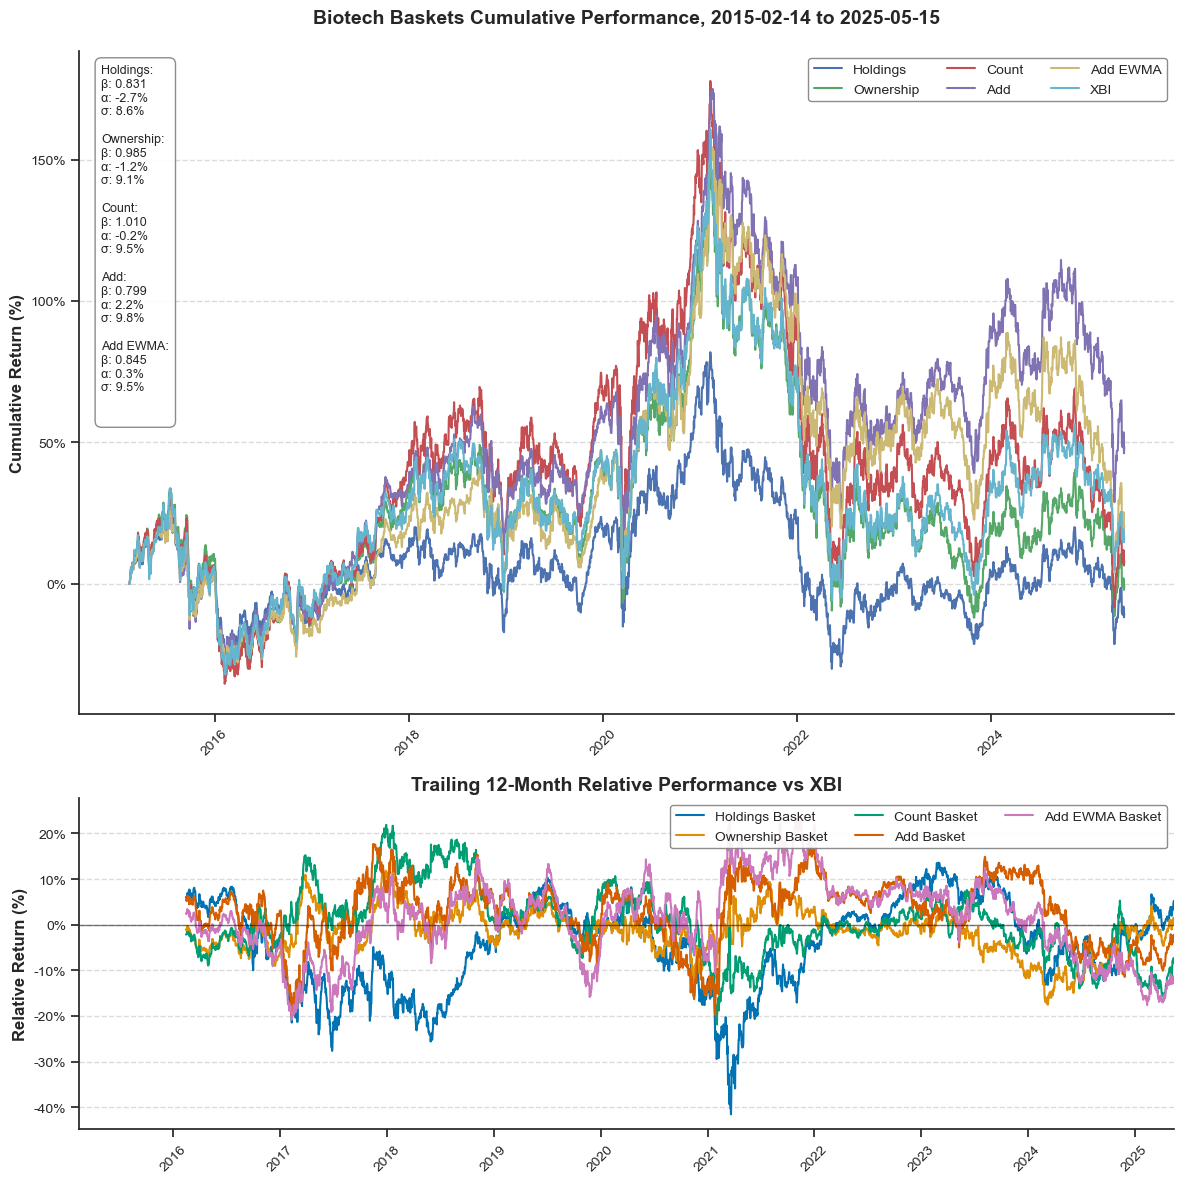

In [83]:
# Get strategy returns and XBI returns
portfolios = {
    'Holdings': all_holdings_port,
    'Ownership': all_ownership_port,
    'Count': all_count_port,
    'Add': all_add_port,
    'Add EWMA': all_add_ewma_port
}

# Get returns for all portfolios
returns = {}
for name, portfolio in portfolios.items():
    returns[name] = bt.get_strategy_returns(portfolio, pd.Timestamp('2025-05-15'))

xbi_returns = bt.sec_rets_df['XBI US'].loc[returns['Holdings'].index[0]:returns['Holdings'].index[-1]]

# Convert to cumulative returns
cumulative_returns = pd.DataFrame()
for name, ret in returns.items():
    cumulative_returns[name] = (1 + ret).cumprod() - 1
cumulative_returns['XBI'] = (1 + xbi_returns).cumprod() - 1

# Calculate trailing 12-month cumulative returns and relative performance
t12m_returns = pd.DataFrame()
relative_returns = pd.DataFrame()
for name, ret in returns.items():
    t12m_returns[name] = (1 + ret).rolling(window=365).apply(lambda x: x.prod()) - 1
    relative_returns[name] = t12m_returns[name] - (1 + xbi_returns).rolling(window=365).apply(lambda x: x.prod()) + 1

# Create a figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), gridspec_kw={'height_ratios': [2, 1]})

# Compute metrics for all strategies
def compute_metrics(strategy_returns, xbi_returns):
    returns_for_regression = pd.DataFrame({
        'strategy': strategy_returns,
        'xbi': xbi_returns
    })
    returns_for_regression = returns_for_regression.dropna()
    returns_for_regression = returns_for_regression[(returns_for_regression['strategy'] != 0) | 
                                                   (returns_for_regression['xbi'] != 0)]
    
    X = sm.add_constant(returns_for_regression['xbi'])
    Y = returns_for_regression['strategy']
    
    model = sm.OLS(Y, X).fit()
    beta = model.params['xbi']
    alpha = model.params['const']
    alpha_annualized = alpha * len(returns_for_regression) / ((strategy_returns.index[-1] - strategy_returns.index[0]).days / 365.25)
    
    idio_vol = model.resid.std()
    idio_vol_annualized = idio_vol * np.sqrt(len(returns_for_regression) / ((strategy_returns.index[-1] - strategy_returns.index[0]).days / 365.25))
    
    return beta, alpha_annualized, idio_vol_annualized

metrics = {}
for name, ret in returns.items():
    metrics[name] = compute_metrics(ret, xbi_returns)

# Set a professional theme and color palette
sns.set_theme(style="ticks", palette="colorblind", font="Arial", font_scale=1.0)  # Reduced font scale
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Plot 1: Cumulative Performance
colors = ["#4C72B0", "#55A868", "#C44E52", "#8172B3", "#CCB974", "#64B5CD"]  # Extended color palette
ax1.grid(True, linestyle='--', alpha=0.7, axis='y')
sns.lineplot(data=cumulative_returns, ax=ax1, linewidth=1.5, palette=colors, dashes=False)  # Reduced line width

# Format the plot
ax1.set_title(f"Biotech Baskets Cumulative Performance, {cumulative_returns.index.min().strftime('%Y-%m-%d')} to {cumulative_returns.index.max().strftime('%Y-%m-%d')}", fontsize=14, fontweight='bold', pad=20)  # Reduced font size
ax1.set_ylabel("Cumulative Return (%)", fontsize=12, fontweight='bold')  # Reduced font size
ax1.set_xlabel("")
ax1.tick_params(axis='both', labelsize=10)  # Reduced font size
ax1.tick_params(axis='x', rotation=45)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*100:.0f}%'))

# Enhance legend
legend = ax1.legend(title="", loc='upper right', ncol=3, frameon=True, framealpha=0.9, 
                   fontsize=10, edgecolor='gray')  # Reduced font size
legend.get_frame().set_linewidth(1)

# Add metrics box with enhanced styling
metrics_text = ""
for name, (beta, alpha, idio_vol) in metrics.items():
    metrics_text += f"{name}:\n"
    metrics_text += f"β: {beta:.3f}\n"  # Simplified beta notation
    metrics_text += f"α: {alpha*100:.1f}%\n"  # Simplified alpha notation
    metrics_text += f"σ: {idio_vol*100:.1f}%\n\n"  # Simplified volatility notation

ax1.text(0.02, 0.98, metrics_text, transform=ax1.transAxes, fontsize=9,  # Reduced font size
        verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', 
                                          facecolor='white', 
                                          edgecolor='gray', 
                                          alpha=0.9,
                                          linewidth=1))

# Plot 2: Trailing 12-month Relative Performance
ax2.grid(True, linestyle='--', alpha=0.7, axis='y')
for name, rel_ret in relative_returns.items():
    sns.lineplot(data=rel_ret, ax=ax2, linewidth=1.5, label=f'{name} Basket')  # Reduced line width

# Format the second plot
ax2.set_title("Trailing 12-Month Relative Performance vs XBI", 
             fontsize=14, fontweight='bold')  # Reduced font size
ax2.set_ylabel("Relative Return (%)", fontsize=12, fontweight='bold')  # Reduced font size
ax2.set_xlabel("")
ax2.tick_params(axis='both', labelsize=10)  # Reduced font size
ax2.tick_params(axis='x', rotation=45)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1.0)  # Reduced line width
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*100:.0f}%'))
ax2.legend(title="", loc='upper right', ncol=3, frameon=True, framealpha=0.9, 
          fontsize=10, edgecolor='gray')  # Reduced font size

# Ensure both plots have the same x-axis range
ax2.set_xlim(cumulative_returns.index.min(), cumulative_returns.index.max())

plt.tight_layout()
plt.show()

In [65]:
# Get the holdings for the specified date
holdings = all_count_chg_port.loc[pd.Timestamp('2025-02-14')].dropna().loc[lambda x: x != 0]
# Sort by size (value) in descending order
sorted_holdings = holdings.sort_values(ascending=False)
# Convert to percentage and print the sorted holdings
percentage_holdings = sorted_holdings * 100
print(percentage_holdings)

# Calculate and print average, max, and min weights across all dates
hhi = (1/(all_count_chg_port**2).sum(axis=1))
max_weight = all_count_chg_port.max().max() * 100
print(f"Avg Effective Concentration: {hhi.mean():.2f}")
print(f"Minimum Effective Concentration: {hhi.min():.2f}")
print(f"Average max weight: {all_count_chg_port.max(axis=1).mean()*100:.2f}%")
print(f"Maximum weight across all dates: {max_weight:.2f}%")

Ticker
SWTX US    6.972754
PCVX US    5.379917
SRPT US    5.379917
BPMC US    4.983430
RVMD US    4.928366
APLS US    4.640454
RNA US     4.101585
AKRO US    4.030675
LEGN US    4.008640
TWST US    3.694695
KRYS US    3.350662
BEAM US    3.344190
SRRK US    3.144207
NUVL US    3.089180
TARS US    2.573813
PTGX US    2.200536
MRUS US    2.059426
CLDX US    2.021566
ZLAB US    1.803469
RCKT US    1.433998
SLNO US    1.387704
QURE US    1.385101
VERA US    1.189461
VRNA US    1.189461
VERV US    1.183451
SYRE US    1.172717
ETNB US    1.105858
ADPT US    1.061297
KYMR US    0.991217
NRIX US    0.991217
IRON US    0.991217
AXSM US    0.991217
ANAB US    0.991217
JANX US    0.991217
REPL US    0.970588
XNCR US    0.882415
MDGL US    0.792974
MIRM US    0.792974
IMVT US    0.792974
FOLD US    0.792974
CYTK US    0.792974
AVDL US    0.792974
RCUS US    0.777096
2105 HK    0.758152
ZYME US    0.580049
IMCR US    0.576063
ALLO US    0.520267
DNTH US    0.477605
VSTM US    0.469339
NGNE US    0.